# Installations

In [1]:
!pip install -U pip setuptools wheel
!pip install -U textstat
!pip install textblob
!pip install --upgrade scikit-learn

     |████████████████████████████████| 1.6MB 15.9MB/s 
Requirement already up-to-date: setuptools in /usr/local/lib/python3.7/dist-packages (57.0.0)
Requirement already up-to-date: wheel in /usr/local/lib/python3.7/dist-packages (0.36.2)
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
     |████████████████████████████████| 99 kB 6.9 MB/s 
     |████████████████████████████████| 1.9 MB 25.6 MB/s 
     |████████████████████████████████| 22.3 MB 71.3 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


# All Imports

In [2]:
import re
import numpy as np 
import pandas as pd
import textstat
import string
import nltk
from copy import deepcopy
from textblob import TextBlob
import spacy
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.feature_extraction import DictVectorizer

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, KFold, StratifiedKFold, ShuffleSplit 

from sklearn.svm import LinearSVC
from sklearn import preprocessing
from nltk.corpus import stopwords
from sklearn import metrics
from sklearn.semi_supervised import SelfTrainingClassifier, LabelSpreading
from sklearn.linear_model import SGDClassifier

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

#pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


# Fetch Data

In [3]:
news_group = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'), shuffle=True)
news_group_data_test = news_group.data
news_group_target_names_test = news_group.target_names
news_group_target_test = news_group.target

# Creating a dataframe from the loaded data
news_df = pd.DataFrame({'news': news_group_data_test, 
                        'class': news_group_target_test})

# Cleaning Text

*   Cleaning
*   Removing stop words



In [4]:
from sklearn.base import BaseEstimator, TransformerMixin
import gensim
class CleanTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
   
    def fit(self,X,y=None):
        return self
    
    
    
    def transform(self,X,y=None):
        # Convert to list
        data = X.tolist()

        # Remove Emails
        data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

        # Remove new line characters
        data = [re.sub('\s+', ' ', sent) for sent in data]

        # Remove distracting single quotes
        data = [re.sub("\'", "", sent) for sent in data]

        def sent_to_words(sentences):
            for sentence in sentences:
                yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
        data_words = list(sent_to_words(data))
        def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
            """https://spacy.io/api/annotation"""
            texts_out = []
            for sent in texts:
                doc = nlp(" ".join(sent)) 
                texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
            return texts_out

        # Initialize spacy 'en' model, keeping only tagger component (for efficiency)
        nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

        # Do lemmatization keeping only Noun, Adj, Verb, Adverb
        data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
        l=[]
        def detokenize(text):
            return "".join([" "+i if not i.startswith("'") and i not in string.punctuation else i for i in text]).strip()
        for row in data_lemmatized:
            l.append(detokenize(row))
        #print(data_lemmatized[:1])
        return l

# POS Tagging

In [5]:
class POSVectorizer():
    def __init__(self):
        pass

    def creatingPOSTags(self, x):
             
        pos_family = {'NOUN' : ['NN','NNS','NNP','NNPS'],
                    'PRON' : ['PRP','PRP$','WP','WP$'], 
                    'VERB' : ['VB','VBD','VBG','VBN','VBP','VBZ'],
                    'ADJ'  : ['JJ','JJR','JJS'],
                    'ADV'  : ['RB','RBR','RBS','WRB']
                    }
            
        count_pos = {'NOUN':0,'PRON':0,'VERB':0,'ADJ':0,'ADV':0}
        
        blob  = TextBlob(x) #converts sentences to tokens
        for tuple in blob.tags: #blob tags contains term and its pos
            #print(tuple)
            pos = list(tuple)[1]
            if pos in pos_family['NOUN']:
                count_pos['NOUN'] = count_pos.get('NOUN')+1
            elif pos in pos_family['PRON']:
                count_pos['PRON'] = count_pos.get('PRON')+1
            elif pos in pos_family['VERB']:
                count_pos['VERB'] = count_pos.get('VERB')+1
            elif pos in pos_family['ADJ']:
                count_pos['ADJ'] = count_pos.get('ADJ')+1
            elif pos in pos_family['ADV']:
                count_pos['ADV'] = count_pos.get('ADV')+1
        return count_pos 
    
    def fit(self, x, y=None):
        return self
    def transform(self, data):
        posVector = POSVectorizer()
        pos_vect = []
        for d in data:
            pos_vect.append(posVector.creatingPOSTags(d))
        return pos_vect

# Convert toArray()

In [6]:
class ToArray(BaseEstimator, TransformerMixin):

    def transform(self, X):
        return X.toarray()

    def fit(self, X, y=None, **fit_params):        
        return self

# Creating Pipelines

In [7]:
bow_transformer = Pipeline(
    steps=[
        ("cleaner", CleanTransformer()),
        ("tfidf", TfidfVectorizer(min_df=5, max_df=0.95)),
        ("toarray", ToArray()), #converting toarray since minmax can't handle sparce matrix
        ("scale", preprocessing.MinMaxScaler())
    ]
)


pos_transformer = Pipeline(
    steps=[
        ("cleaner", CleanTransformer()),
        ("pos", POSVectorizer()),
        ("dict_vect", DictVectorizer()),
        ("toarray", ToArray()), #converting toarray since minmax can't handle sparce matrix
        ("scale", preprocessing.MinMaxScaler())
    ]
)

# BOW Transform

In [11]:
X=bow_transformer.fit_transform(news_df['news'])

In [ ]:
print(X.shape)

(18846, 16623)


# Feature Selection (Chi2)

In [12]:
X_new=SelectKBest(chi2, k=5000).fit_transform(X,news_df['class'])

# POS Transform

In [13]:
Y=pos_transformer.fit_transform(news_df['news'])

In [ ]:
print(Y.shape)

(18846, 5)


# Concatenate features

In [14]:
features=np.concatenate((X_new,Y),axis=1)

# EM

In [15]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np

from copy import deepcopy
from scipy.sparse import csr_matrix, vstack
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from scipy.linalg import get_blas_funcs
from sklearn.semi_supervised import LabelPropagation, LabelSpreading

class Semi_EM_MultinomialNB():
    """
    Naive Bayes classifier for multinomial models for semi-supervised learning.
    
    Use both labeled and unlabeled data to train NB classifier, update parameters
    using unlabeled data, and all data to evaluate performance of classifier. Optimize
    classifier using Expectation-Maximization algorithm.
    """
    def __init__(self, alpha=1.0, fit_prior=True, class_prior=None, max_iter=30, tol=1e-6, print_log_lkh=True):
        self.alpha = alpha
        self.fit_prior = fit_prior
        self.class_prior = class_prior
        self.clf = MultinomialNB(alpha=self.alpha, fit_prior=self.fit_prior, class_prior=self.class_prior)
        self.log_lkh = -np.inf # log likelihood
        self.max_iter = max_iter # max number of EM iterations
        self.tol = tol # tolerance of log likelihood increment
        self.feature_log_prob_ = np.array([]) # Empirical log probability of features given a class, P(x_i|y).
        self.coef_ = np.array([]) # Mirrors feature_log_prob_ for interpreting MultinomialNB as a linear model.
        self.print_log_lkh = print_log_lkh # if True, print log likelihood during EM iterations

    def fit(self, X_l, y_l, X_u):
        """
        Initialize the parameter using labeled data only.
        Assume unlabeled class as missing values, apply EM on unlabeled data to refine classifier.
        """
        n_ul_docs = X_u.shape[0] # number of unlabeled samples
        n_l_docs = X_l.shape[0] # number of labeled samples
        # initialization (n_docs = n_ul_docs)
        clf = deepcopy(self.clf)# build new copy of classifier
        clf.fit(X_l, y_l) # use labeled data only to initialize classifier parameters
        prev_log_lkh = self.log_lkh # record log likelihood of previous EM iteration
        lp_w_c = clf.feature_log_prob_ # log CP of word given class [n_classes, n_words]
        b_w_d = (X_u > 0) # words in each document [n_docs, n_words]
        lp_d_c = get_blas_funcs("gemm", [lp_w_c, b_w_d.T]) # log CP of doc given class [n_classes, n_docs]
        lp_d_c = lp_d_c(alpha=1.0, a=lp_w_c, b=b_w_d.T) 
        lp_c = np.matrix(clf.class_log_prior_).T # log prob of classes [n_classes, 1]
        lp_c = np.repeat(lp_c, n_ul_docs, axis=1) # repeat for each doc [n_classes, n_docs]
        lp_dc = lp_d_c + lp_c # joint prob of doc and class [n_classes, n_docs]
        p_c_d = clf.predict_proba(X_u) # weight of each class in each doc [n_docs, n_classes]
        expectation = get_blas_funcs("gemm", [p_c_d, lp_dc]) # expectation of log likelihood over all unlabeled docs
        expectation = expectation(alpha=1.0, a=p_c_d, b=lp_dc).trace() 
        self.clf = deepcopy(clf)
        self.log_lkh = expectation
        if self.print_log_lkh:
            print("Initial expected log likelihood = %0.3f\n" % expectation)
        # Loop until log likelihood does not improve
        iter_count = 0 # count EM iteration
        while (self.log_lkh-prev_log_lkh>=self.tol and iter_count<self.max_iter):
        # while (iter_count<self.max_iter):
            iter_count += 1
            if self.print_log_lkh:
                print("EM iteration #%d" % iter_count) # debug
            # E-step: Estimate class membership of unlabeled documents
            y_u = clf.predict(X_u)
            # M-step: Re-estimate classifier parameters
            X = vstack([X_l, X_u])
            y = np.concatenate((y_l, y_u), axis=0)
            clf.fit(X, y)
            # check convergence: update log likelihood
            p_c_d = clf.predict_proba(X_u)
            lp_w_c = clf.feature_log_prob_ # log CP of word given class [n_classes, n_words]
            b_w_d = (X_u > 0) # words in each document
            lp_d_c = get_blas_funcs("gemm", [lp_w_c, b_w_d.transpose()]) # log CP of doc given class [n_classes, n_docs]
            lp_d_c = lp_d_c(alpha=1.0, a=lp_w_c, b=b_w_d.transpose()) 
            lp_c = np.matrix(clf.class_log_prior_).T # log prob of classes [n_classes, 1]
            lp_c = np.repeat(lp_c, n_ul_docs, axis=1) # repeat for each doc [n_classes, n_docs]
            lp_dc = lp_d_c + lp_c  # joint prob of doc and class [n_classes, n_docs]
            expectation = get_blas_funcs("gemm", [p_c_d, lp_dc]) # expectation of log likelihood over all unlabeled docs
            expectation = expectation(alpha=1.0, a=p_c_d, b=lp_dc).trace() 
            if self.print_log_lkh:
                print("\tExpected log likelihood = %0.3f" % expectation)
            if (expectation-self.log_lkh >= self.tol):
                prev_log_lkh = self.log_lkh
                self.log_lkh = expectation
                self.clf = deepcopy(clf)
            else:
                break
        self.feature_log_prob_ = self.clf.feature_log_prob_
        self.coef_ = self.clf.coef_
        return self

   
    def predict(self, X):
        return self.clf.predict(X)

    def score(self, X, y):
        return self.clf.score(X, y)

    def get_params(deep=True):
        return self.clf.get_params(deep)

    def __str__(self):
        return self.clf.__str__()

# Cross Validation

In [16]:
def cross_validation(clf, data_X, data_y, unlabeled,X_u, n_folds=5):
    print('=' * 80)
    print("Validation: ")
    print(clf)
    kf = StratifiedKFold(n_splits=n_folds)
    start_time = time()
    train_scores = list() # training accuracy
    fold_count = 1
    original_clf = deepcopy(clf)
    avg_accuracy = 0
    for train_ids, valid_ids in kf.split(data_X, data_y):
        cv_clf = deepcopy(original_clf)
        print("Fold # %d" % fold_count)
        fold_count += 1
        train_X, train_y, valid_X, valid_y = data_X[train_ids], data_y[train_ids], data_X[valid_ids], data_y[valid_ids]
        if unlabeled==True:
            cv_clf.fit(train_X, train_y, X_u)
        else:
            cv_clf.fit(train_X, train_y)
        pred = cv_clf.predict(valid_X)
        scores = dict()
        scores['accuracy'] = metrics.accuracy_score(valid_y, pred)
        scores['recall'] = metrics.recall_score(valid_y, pred, average='macro')
        scores['precision'] = metrics.precision_score(valid_y, pred, average='macro')
        scores['f1_score'] = metrics.f1_score(valid_y, pred, average='macro')
        train_scores.append(scores)
        avg_accuracy += scores['accuracy']
    train_time = time() - start_time
    print("Validation time: %0.3f seconds" % train_time)
    print("Average training accuracy: %0.3f" % (avg_accuracy/n_folds))
    return train_scores, train_time

# Train test split

In [17]:
train_X, test_X, train_y, test_y = train_test_split(features,news_df['class'], test_size=0.2, stratify=news_df['class'])
print("Training set size: %8d\tTest set size: %8d" % (len(train_X), len(test_X)))
# Divide train data set into labeled and unlabeled data sets
X_l, X_u, y_l, y_u = train_test_split(train_X, train_y, test_size=10000, stratify=train_y)
experiments = np.logspace(2.3, 3.7, num=20, base=10, dtype='int')
print (X_l.shape, X_u.shape)

Training set size:    15076	Test set size:     3770
(5076, 5005) (10000, 5005)


In [18]:
y_l=y_l.to_numpy()
y_u=y_u.to_numpy()
print(type(X_l),type(X_u),type(y_l),type(y_u))

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


# MultinomialNB

In [19]:
from time import time
# Cross validation for Naive Bayes classifier 
# using labeled data set only
nb_cv_scores = list()
nb_cv_times = list()
for n_l_docs in experiments:
    nb_clf = MultinomialNB(alpha=1e-2)
    cv_scores, cv_time = cross_validation(nb_clf, X_l[:n_l_docs,], y_l[:n_l_docs],False,X_u)
    nb_cv_scores.append(cv_scores)
    nb_cv_times.append(cv_time)
    print("Number of labeled documents: %6d" % n_l_docs)

Validation: 
MultinomialNB(alpha=0.01)
Fold # 1
Fold # 2
Fold # 3
Fold # 4
Fold # 5
Validation time: 0.074 seconds
Average training accuracy: 0.342
Number of labeled documents:    199
Validation: 
MultinomialNB(alpha=0.01)
Fold # 1
Fold # 2
Fold # 3
Fold # 4
Fold # 5
Validation time: 0.079 seconds
Average training accuracy: 0.352
Number of labeled documents:    236
Validation: 
MultinomialNB(alpha=0.01)
Fold # 1
Fold # 2
Fold # 3
Fold # 4
Fold # 5
Validation time: 0.086 seconds
Average training accuracy: 0.364
Number of labeled documents:    280
Validation: 
MultinomialNB(alpha=0.01)
Fold # 1
Fold # 2
Fold # 3
Fold # 4
Fold # 5
Validation time: 0.098 seconds
Average training accuracy: 0.435
Number of labeled documents:    331
Validation: 
MultinomialNB(alpha=0.01)
Fold # 1
Fold # 2
Fold # 3
Fold # 4
Fold # 5
Validation time: 0.106 seconds
Average training accuracy: 0.458
Number of labeled documents:    393
Validation: 
MultinomialNB(alpha=0.01)
Fold # 1
Fold # 2
Fold # 3
Fold # 4
Fold 

# Semi_EM_MultinomialNB

In [20]:
# Cross validation for semisupervised EM Naive Bayes classifier 
# using both labeled and unlabeled data set
em_nb_cv_scores = list()
em_nb_cv_times = list()
for n_l_docs in experiments:
    em_nb_clf = Semi_EM_MultinomialNB(alpha=1e-2, tol=100, print_log_lkh=False) # semi supervised EM based Naive Bayes classifier
    cv_scores, cv_time = cross_validation(em_nb_clf, X_l[:n_l_docs,], y_l[:n_l_docs],True,X_u)
    em_nb_cv_scores.append(cv_scores)
    em_nb_cv_times.append(cv_time)
    print("Number of labeled documents: %6d" % n_l_docs)

Validation: 
MultinomialNB(alpha=0.01)
Fold # 1
Fold # 2
Fold # 3
Fold # 4
Fold # 5
Validation time: 50.665 seconds
Average training accuracy: 0.493
Number of labeled documents:    199
Validation: 
MultinomialNB(alpha=0.01)
Fold # 1
Fold # 2
Fold # 3
Fold # 4
Fold # 5
Validation time: 50.639 seconds
Average training accuracy: 0.496
Number of labeled documents:    236
Validation: 
MultinomialNB(alpha=0.01)
Fold # 1
Fold # 2
Fold # 3
Fold # 4
Fold # 5
Validation time: 50.352 seconds
Average training accuracy: 0.514
Number of labeled documents:    280
Validation: 
MultinomialNB(alpha=0.01)
Fold # 1
Fold # 2
Fold # 3
Fold # 4
Fold # 5
Validation time: 46.244 seconds
Average training accuracy: 0.502
Number of labeled documents:    331
Validation: 
MultinomialNB(alpha=0.01)
Fold # 1
Fold # 2
Fold # 3
Fold # 4
Fold # 5
Validation time: 43.978 seconds
Average training accuracy: 0.514
Number of labeled documents:    393
Validation: 
MultinomialNB(alpha=0.01)
Fold # 1
Fold # 2
Fold # 3
Fold # 4


# Accuracy

Text(0.5, 1.0, 'Cross-Validation Average Accuracy vs Number of Labeled Documents in Training Set')

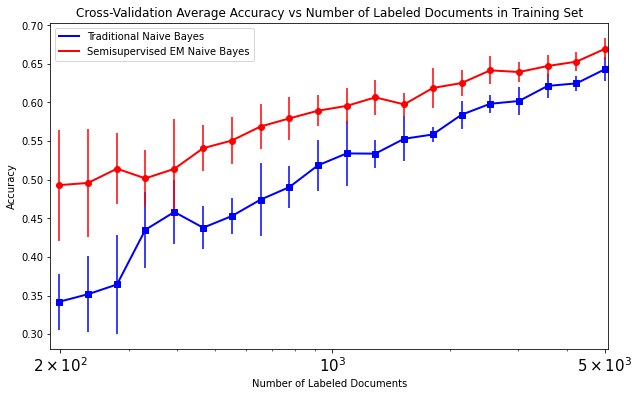

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
# plot CV accuracy comparisons
nb_score_mean = list()
nb_score_err = list()
em_nb_score_mean = list()
em_nb_score_err = list()
for idx in range(len(experiments)):
    nb_scores = [value['accuracy'] for value in nb_cv_scores[idx]]
    nb_score_mean.append(np.mean(nb_scores))
    nb_score_err.append(np.std(nb_scores))
    em_nb_scores = [value['accuracy'] for value in em_nb_cv_scores[idx]]
    em_nb_score_mean.append(np.mean(em_nb_scores))
    em_nb_score_err.append(np.std(em_nb_scores))
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.plot(experiments, nb_score_mean, color='b', linewidth=2, label='Traditional Naive Bayes')
ax.errorbar(experiments, nb_score_mean, yerr=nb_score_err, fmt='s', color='b')
ax.plot(experiments, em_nb_score_mean, color='r', linewidth=2, label='Semisupervised EM Naive Bayes')
ax.errorbar(experiments, em_nb_score_mean, yerr=em_nb_score_err, fmt='o', color='r')
ax.set_xlabel('Number of Labeled Documents')
ax.set_ylabel('Accuracy')
ax.set_xlim(left=np.min(experiments)-10, right=np.max(experiments)+100)
ax.set_xscale('log')
ax.set_xticks([200, 1000, 5000]) 
ax.set_xticklabels([r'$2\times10^2$', r'$10^3$', r'$5\times10^3$'], fontsize=15)
plt.legend(loc='upper left')
plt.title('Cross-Validation Average Accuracy vs Number of Labeled Documents in Training Set')

# F1 Score

Text(0.5, 1.0, 'Cross-Validation Average F1 Score vs Number of Labeled Documents in Training Set')

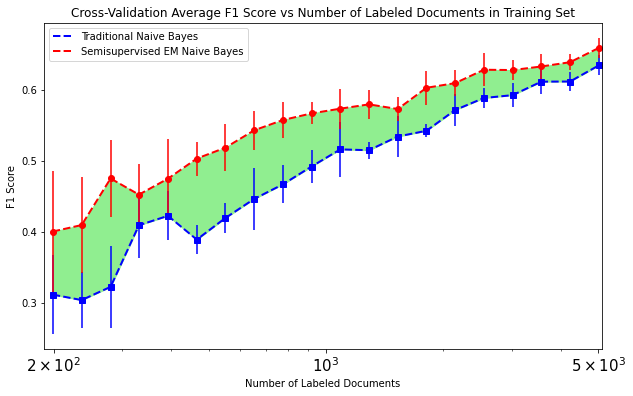

In [22]:
# plot CV F1 Score comparisons
nb_score_mean = list()
nb_score_err = list()
em_nb_score_mean = list()
em_nb_score_err = list()
for idx in range(len(experiments)):
    nb_scores = [value['f1_score'] for value in nb_cv_scores[idx]]
    nb_score_mean.append(np.mean(nb_scores))
    nb_score_err.append(np.std(nb_scores))
    em_nb_scores = [value['f1_score'] for value in em_nb_cv_scores[idx]]
    em_nb_score_mean.append(np.mean(em_nb_scores))
    em_nb_score_err.append(np.std(em_nb_scores))
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.plot(experiments, nb_score_mean, color='b', linestyle='--', linewidth=2, label='Traditional Naive Bayes')
ax.errorbar(experiments, nb_score_mean, yerr=nb_score_err, fmt='s', color='b')
ax.plot(experiments, em_nb_score_mean, color='r', linestyle='--', linewidth=2, label='Semisupervised EM Naive Bayes')
ax.errorbar(experiments, em_nb_score_mean, yerr=em_nb_score_err, fmt='o', color='r')
ax.fill_between(experiments, nb_score_mean, em_nb_score_mean, color='lightgreen')
ax.set_xlabel('Number of Labeled Documents')
ax.set_ylabel('F1 Score')
ax.set_xlim(left=np.min(experiments)-10, right=np.max(experiments)+100)
ax.set_xscale('log')
ax.set_xticks([200, 1000, 5000]) 
ax.set_xticklabels([r'$2\times10^2$', r'$10^3$', r'$5\times10^3$'], fontsize=15)
plt.legend(loc='upper left')
plt.title('Cross-Validation Average F1 Score vs Number of Labeled Documents in Training Set')

# Precision & Recall

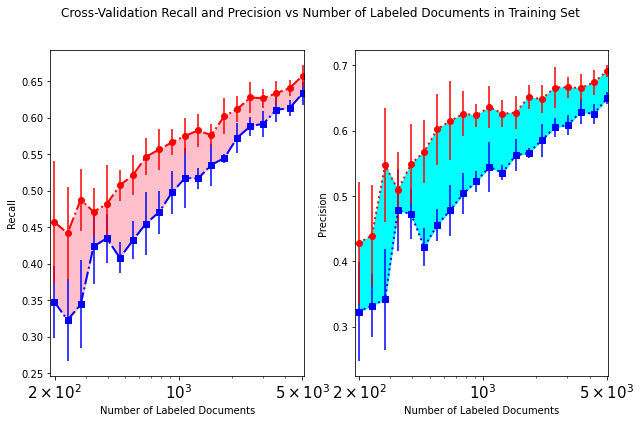

In [23]:
# plot CV accuracy comparisons
nb_score_mean = list()
nb_score_err = list()
em_nb_score_mean = list()
em_nb_score_err = list()
for idx in range(len(experiments)):
    nb_scores = [value['recall'] for value in nb_cv_scores[idx]]
    nb_score_mean.append(np.mean(nb_scores))
    nb_score_err.append(np.std(nb_scores))
    em_nb_scores = [value['recall'] for value in em_nb_cv_scores[idx]]
    em_nb_score_mean.append(np.mean(em_nb_scores))
    em_nb_score_err.append(np.std(em_nb_scores))
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(121)
ax1.plot(experiments, nb_score_mean, color='b', linestyle='-.', linewidth=2, label='Traditional Naive Bayes')
ax1.errorbar(experiments, nb_score_mean, yerr=nb_score_err, fmt='s', color='b')
ax1.plot(experiments, em_nb_score_mean, color='r', linestyle='-.', linewidth=2, label='Semisupervised EM Naive Bayes')
ax1.errorbar(experiments, em_nb_score_mean, yerr=em_nb_score_err, fmt='o', color='r')
ax1.fill_between(experiments, nb_score_mean, em_nb_score_mean, color='pink')
ax1.set_xlabel('Number of Labeled Documents')
ax1.set_ylabel('Recall')
ax1.set_xlim(left=np.min(experiments)-10, right=np.max(experiments)+100)
ax1.set_xscale('log')
ax1.set_xticks([200, 1000, 5000]) 
ax1.set_xticklabels([r'$2\times10^2$', r'$10^3$', r'$5\times10^3$'], fontsize=15)
nb_score_mean = list()
nb_score_err = list()
em_nb_score_mean = list()
em_nb_score_err = list()
for idx in range(len(experiments)):
    nb_scores = [value['precision'] for value in nb_cv_scores[idx]]
    nb_score_mean.append(np.mean(nb_scores))
    nb_score_err.append(np.std(nb_scores))
    em_nb_scores = [value['precision'] for value in em_nb_cv_scores[idx]]
    em_nb_score_mean.append(np.mean(em_nb_scores))
    em_nb_score_err.append(np.std(em_nb_scores))
ax2 = fig.add_subplot(122)
ax2.plot(experiments, nb_score_mean, color='b', linestyle=':', linewidth=2, label='Traditional Naive Bayes')
ax2.errorbar(experiments, nb_score_mean, yerr=nb_score_err, fmt='s', color='b')
ax2.plot(experiments, em_nb_score_mean, color='r', linestyle=':', linewidth=2, label='Semisupervised EM Naive Bayes')
ax2.errorbar(experiments, em_nb_score_mean, yerr=em_nb_score_err, fmt='o', color='r')
ax2.fill_between(experiments, nb_score_mean, em_nb_score_mean, color='aqua')
ax2.set_xlabel('Number of Labeled Documents')
ax2.set_ylabel('Precision')
ax2.set_xlim(left=np.min(experiments)-10, right=np.max(experiments)+100)
ax2.set_xscale('log')
ax2.set_xticks([200, 1000, 5000]) 
ax2.set_xticklabels([r'$2\times10^2$', r'$10^3$', r'$5\times10^3$'], fontsize=15)
fig.suptitle('Cross-Validation Recall and Precision vs Number of Labeled Documents in Training Set')
plt.show()

# Accuracy Test Data NB



In [24]:
# Evaluate original NB classifier using test data set
nb_test_scores = dict()
nb_test_scores['accuracy'] = list()
nb_test_scores['recall'] = list()
nb_test_scores['precision'] = list()
nb_test_scores['f1_score'] = list()
for n_l_docs in experiments:
    nb_clf = MultinomialNB(alpha=1e-2).fit(X_l[:n_l_docs,], y_l[:n_l_docs])
    pred = nb_clf.predict(test_X)
    accuracy = metrics.accuracy_score(test_y, pred)
    nb_test_scores['accuracy'].append(accuracy)
    nb_test_scores['recall'].append(metrics.recall_score(test_y, pred, average='macro'))
    nb_test_scores['precision'].append(metrics.precision_score(test_y, pred, average='macro'))
    nb_test_scores['f1_score'].append(metrics.f1_score(test_y, pred, average='macro'))
    print("%6d labeled documents lead to accuracy of %.3f" % (n_l_docs, accuracy))

   199 labeled documents lead to accuracy of 0.372
   236 labeled documents lead to accuracy of 0.391
   280 labeled documents lead to accuracy of 0.402
   331 labeled documents lead to accuracy of 0.418
   393 labeled documents lead to accuracy of 0.428
   466 labeled documents lead to accuracy of 0.455
   552 labeled documents lead to accuracy of 0.467
   654 labeled documents lead to accuracy of 0.477
   775 labeled documents lead to accuracy of 0.495
   918 labeled documents lead to accuracy of 0.513
  1088 labeled documents lead to accuracy of 0.535
  1289 labeled documents lead to accuracy of 0.551
  1528 labeled documents lead to accuracy of 0.569
  1810 labeled documents lead to accuracy of 0.579
  2145 labeled documents lead to accuracy of 0.593
  2542 labeled documents lead to accuracy of 0.606
  3012 labeled documents lead to accuracy of 0.617
  3569 labeled documents lead to accuracy of 0.634
  4229 labeled documents lead to accuracy of 0.645
  5011 labeled documents lead t

# Accuracy Test Data EM_NB

In [25]:
# Evaluate semi-supervised EM NB classifier using test data set
em_nb_test_scores = dict()
em_nb_test_scores['accuracy'] = list()
em_nb_test_scores['recall'] = list()
em_nb_test_scores['precision'] = list()
em_nb_test_scores['f1_score'] = list()
for n_l_docs in experiments:
    em_nb_clf = Semi_EM_MultinomialNB(alpha=1e-2, tol=100, print_log_lkh=False).fit(X_l[:n_l_docs,], y_l[:n_l_docs], X_u)
    pred = em_nb_clf.predict(test_X)
    accuracy = metrics.accuracy_score(test_y, pred)
    em_nb_test_scores['accuracy'].append(accuracy)
    em_nb_test_scores['recall'].append(metrics.recall_score(test_y, pred, average='macro'))
    em_nb_test_scores['precision'].append(metrics.precision_score(test_y, pred, average='macro'))
    em_nb_test_scores['f1_score'].append(metrics.f1_score(test_y, pred, average='macro'))
    print("%6d labeled documents lead to accuracy of %.3f" % (n_l_docs, accuracy))

   199 labeled documents lead to accuracy of 0.508
   236 labeled documents lead to accuracy of 0.528
   280 labeled documents lead to accuracy of 0.536
   331 labeled documents lead to accuracy of 0.545
   393 labeled documents lead to accuracy of 0.545
   466 labeled documents lead to accuracy of 0.553
   552 labeled documents lead to accuracy of 0.584
   654 labeled documents lead to accuracy of 0.588
   775 labeled documents lead to accuracy of 0.585
   918 labeled documents lead to accuracy of 0.602
  1088 labeled documents lead to accuracy of 0.618
  1289 labeled documents lead to accuracy of 0.629
  1528 labeled documents lead to accuracy of 0.631
  1810 labeled documents lead to accuracy of 0.631
  2145 labeled documents lead to accuracy of 0.631
  2542 labeled documents lead to accuracy of 0.638
  3012 labeled documents lead to accuracy of 0.648
  3569 labeled documents lead to accuracy of 0.657
  4229 labeled documents lead to accuracy of 0.663
  5011 labeled documents lead t

Text(0.5, 1.0, 'Test Accuracy vs Number of Labeled Documents in Training Set')

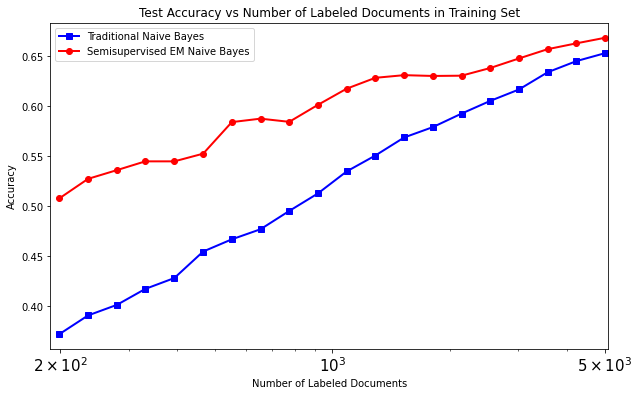

In [26]:
# Plot and compare test accuracy metrics
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.plot(experiments, nb_test_scores['accuracy'], color='b', marker='s', linewidth=2, label='Traditional Naive Bayes')
ax.plot(experiments, em_nb_test_scores['accuracy'], color='r', marker='o', linewidth=2, label='Semisupervised EM Naive Bayes')
ax.set_xlabel('Number of Labeled Documents')
ax.set_ylabel('Accuracy')
ax.set_xlim(left=np.min(experiments)-10, right=np.max(experiments)+100)
ax.set_xscale('log')
ax.set_xticks([200, 1000, 5000]) 
ax.set_xticklabels([r'$2\times10^2$', r'$10^3$', r'$5\times10^3$'], fontsize=15)
plt.legend(loc='upper left')
plt.title('Test Accuracy vs Number of Labeled Documents in Training Set')

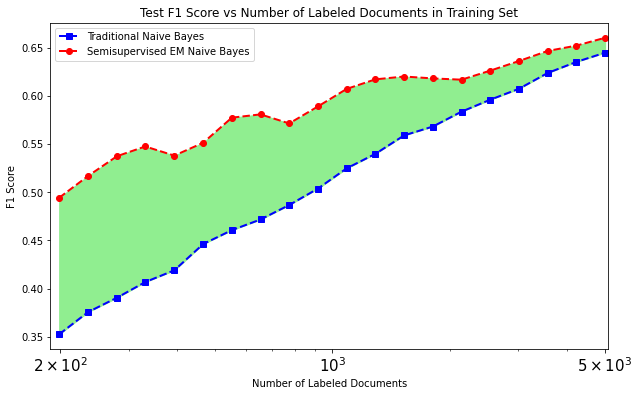

In [27]:
# Plot and compare test f1 score metrics
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.plot(experiments, nb_test_scores['f1_score'], color='b', marker='s', linestyle='--', linewidth=2, label='Traditional Naive Bayes')
ax.plot(experiments, em_nb_test_scores['f1_score'], color='r', marker='o', linestyle='--', linewidth=2, label='Semisupervised EM Naive Bayes')
ax.fill_between(experiments, nb_test_scores['f1_score'], em_nb_test_scores['f1_score'], color='lightgreen')
ax.set_xlabel('Number of Labeled Documents')
ax.set_ylabel('F1 Score')
ax.set_xlim(left=np.min(experiments)-10, right=np.max(experiments)+100)
ax.set_xscale('log')
ax.set_xticks([200, 1000, 5000]) 
ax.set_xticklabels([r'$2\times10^2$', r'$10^3$', r'$5\times10^3$'], fontsize=15)
plt.legend(loc='upper left')
plt.title('Test F1 Score vs Number of Labeled Documents in Training Set')
plt.savefig('BOWNB5.png')

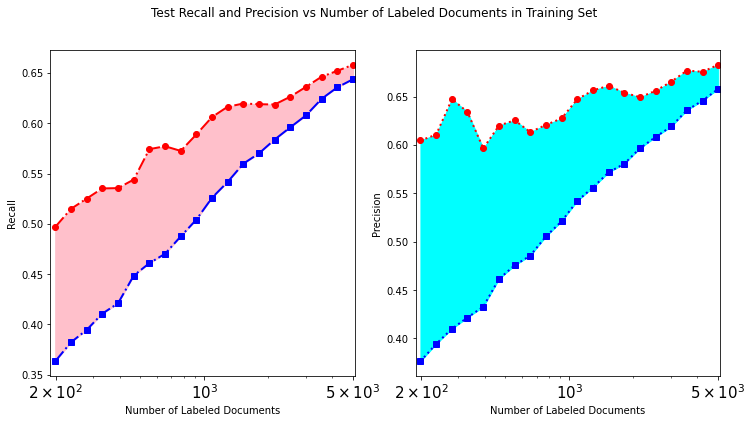

In [28]:
# Plot and compare test recall and precisions metrics
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121)
ax1.plot(experiments, nb_test_scores['recall'], color='b', marker='s', linestyle='-.', linewidth=2, label='Traditional Naive Bayes')
ax1.plot(experiments, em_nb_test_scores['recall'], color='r', marker='o', linestyle='-.', linewidth=2, label='Semisupervised EM Naive Bayes')
ax1.fill_between(experiments, nb_test_scores['recall'], em_nb_test_scores['recall'], color='pink')
ax1.set_xlabel('Number of Labeled Documents')
ax1.set_ylabel('Recall')
ax1.set_xlim(left=np.min(experiments)-10, right=np.max(experiments)+100)
ax1.set_xscale('log')
ax1.set_xticks([200, 1000, 5000]) 
ax1.set_xticklabels([r'$2\times10^2$', r'$10^3$', r'$5\times10^3$'], fontsize=15)

ax2 = fig.add_subplot(122)
ax2.plot(experiments, nb_test_scores['precision'], color='b', marker='s', linestyle=':', linewidth=2, label='Traditional Naive Bayes')
ax2.plot(experiments, em_nb_test_scores['precision'], color='r', marker='o', linestyle=':', linewidth=2, label='Semisupervised EM Naive Bayes')
ax2.fill_between(experiments, nb_test_scores['precision'], em_nb_test_scores['precision'], color='aqua')
ax2.set_xlabel('Number of Labeled Documents')
ax2.set_ylabel('Precision')
ax2.set_xlim(left=np.min(experiments)-10, right=np.max(experiments)+100)
ax2.set_xscale('log')
ax2.set_xticks([200, 1000, 5000]) 
ax2.set_xticklabels([r'$2\times10^2$', r'$10^3$', r'$5\times10^3$'], fontsize=15)
fig.suptitle('Test Recall and Precision vs Number of Labeled Documents in Training Set')
plt.show()

# Classification Report

In [29]:
# details of classification accuracy metrics
print(metrics.classification_report(test_y, pred, target_names=news_group_target_names_test))

                          precision    recall  f1-score   support

             alt.atheism       0.55      0.50      0.52       160
           comp.graphics       0.59      0.66      0.62       195
 comp.os.ms-windows.misc       0.60      0.57      0.58       197
comp.sys.ibm.pc.hardware       0.61      0.59      0.60       196
   comp.sys.mac.hardware       0.66      0.69      0.67       193
          comp.windows.x       0.76      0.71      0.73       198
            misc.forsale       0.75      0.64      0.69       195
               rec.autos       0.66      0.63      0.65       198
         rec.motorcycles       0.74      0.65      0.69       199
      rec.sport.baseball       0.84      0.75      0.80       199
        rec.sport.hockey       0.89      0.84      0.87       200
               sci.crypt       0.42      0.85      0.56       198
         sci.electronics       0.74      0.56      0.64       197
                 sci.med       0.86      0.81      0.84       198
         

# Heatmap

Text(0.5, 1.0, 'Confusion Matrix')

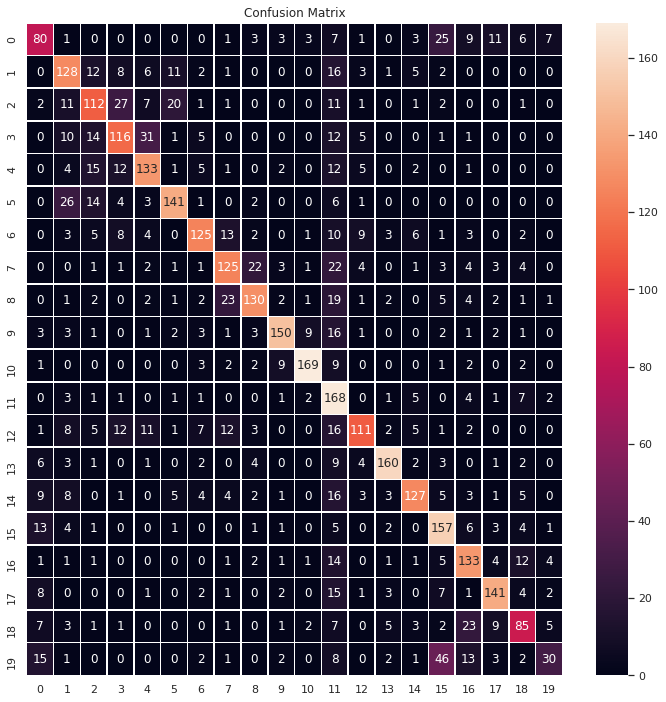

In [30]:
# plot confusion matrix for test dataset
plt.figure(figsize=(12,12))
sns.set()
sns.heatmap(metrics.confusion_matrix(test_y, pred), annot=True, fmt="d", linewidths=.5)
plt.title("Confusion Matrix")

# SGD

In [31]:
sdg_params = dict(alpha=1e-5, penalty='l2', loss='log')

for n_l_docs in experiments:
    sgd_clf = SGDClassifier(**sdg_params)
    cv_scores, cv_time = cross_validation(sgd_clf, X_l[:n_l_docs,], y_l[:n_l_docs],False,X_u) 

Validation: 
SGDClassifier(alpha=1e-05, loss='log')
Fold # 1
Fold # 2
Fold # 3
Fold # 4
Fold # 5
Validation time: 2.694 seconds
Average training accuracy: 0.236
Validation: 
SGDClassifier(alpha=1e-05, loss='log')
Fold # 1
Fold # 2
Fold # 3
Fold # 4
Fold # 5
Validation time: 3.854 seconds
Average training accuracy: 0.318
Validation: 
SGDClassifier(alpha=1e-05, loss='log')
Fold # 1
Fold # 2
Fold # 3
Fold # 4
Fold # 5
Validation time: 4.772 seconds
Average training accuracy: 0.293
Validation: 
SGDClassifier(alpha=1e-05, loss='log')
Fold # 1
Fold # 2
Fold # 3
Fold # 4
Fold # 5
Validation time: 6.442 seconds
Average training accuracy: 0.338
Validation: 
SGDClassifier(alpha=1e-05, loss='log')
Fold # 1
Fold # 2
Fold # 3
Fold # 4
Fold # 5
Validation time: 7.709 seconds
Average training accuracy: 0.323
Validation: 
SGDClassifier(alpha=1e-05, loss='log')
Fold # 1
Fold # 2
Fold # 3
Fold # 4
Fold # 5
Validation time: 9.250 seconds
Average training accuracy: 0.365
Validation: 
SGDClassifier(alpha=1

# Mask

In [32]:
y_mask = np.random.rand(len(train_y)) < 0.2
y_masked_class = train_y.to_numpy()
y_masked_class[~y_mask] = -1

# LabelPropagation

In [33]:
from time import time
for n_l_docs in experiments:
    lbl_clf = LabelPropagation(max_iter=2000)
    cv_scores, cv_time = cross_validation(lbl_clf, train_X[:n_l_docs,], y_masked_class[:n_l_docs],False,test_X)

Validation: 
LabelPropagation(max_iter=2000)
Fold # 1
Fold # 2
Fold # 3
Fold # 4
Fold # 5
Validation time: 0.087 seconds
Average training accuracy: 0.010
Validation: 
LabelPropagation(max_iter=2000)
Fold # 1
Fold # 2
Fold # 3
Fold # 4
Fold # 5
Validation time: 0.102 seconds
Average training accuracy: 0.008
Validation: 
LabelPropagation(max_iter=2000)
Fold # 1
Fold # 2
Fold # 3
Fold # 4
Fold # 5
Validation time: 0.120 seconds
Average training accuracy: 0.011
Validation: 
LabelPropagation(max_iter=2000)
Fold # 1
Fold # 2
Fold # 3
Fold # 4
Fold # 5
Validation time: 0.139 seconds
Average training accuracy: 0.000
Validation: 
LabelPropagation(max_iter=2000)
Fold # 1
Fold # 2
Fold # 3
Fold # 4
Fold # 5
Validation time: 0.170 seconds
Average training accuracy: 0.010
Validation: 
LabelPropagation(max_iter=2000)
Fold # 1
Fold # 2
Fold # 3
Fold # 4
Fold # 5
Validation time: 0.216 seconds
Average training accuracy: 0.006
Validation: 
LabelPropagation(max_iter=2000)
Fold # 1
Fold # 2
Fold # 3
Fold